# 🗽 NYC Taxi Trip Duration - EDA (Exploratory Data Analysis)
## 📌 Problem Overview
This notebook explores the **New York City Taxi Trip Duration** dataset from Kaggle.  
The goal of the competition is to **predict the total ride duration of taxi trips** in NYC  
based on various trip attributes such as:

- Pickup and dropoff location  
- Datetime  
- Passenger count  
- And more  


---

## 🎯 Objective of this Notebook
The focus of this notebook is **Exploratory Data Analysis (EDA)** — to better understand the data, uncover hidden patterns, and identify potential features for modeling.

We will:
- Understood the structure and content of the dataset through .info(), .describe(), and checking for missing values.
- Explored the distribution of the target variable trip_duration and applied a log transformation to handle skewness.
- Extracted and visualized temporal features such as hour of day, day of week, month, and day of year from pickup_datetime.
- Analyzed passenger count values, including identifying and removing unrealistic outliers.
- Computed straight-line distances between pickup and dropoff points using the Haversine formula.
-    Use this analysis to create a categorical feature for traffic congestion levels, with categories such as:
    0: Light traffic
    1: Heavy traffic
- Identified potential data quality issues and patterns that can inform future feature engineering or cleaning steps.

No modeling will be done here — the purpose is to gather **insightful observations** to guide the development of predictive models.

---

## 📂 Dataset Fields

| Column | Description |
|--------|-------------|
| `id` | Unique identifier for each trip |
| `vendor_id` | Vendor providing the trip record |
| `pickup_datetime` | Date and time when the meter was engaged |
| `dropoff_datetime` | Date and time when the meter was disengaged |
| `passenger_count` | Number of passengers |
| `pickup_longitude` / `pickup_latitude` | Coordinates where the trip started |
| `dropoff_longitude` / `dropoff_latitude` | Coordinates where the trip ended |
| `store_and_fwd_flag` | Flag for whether the record was stored before forwarding |
| `trip_duration` | Duration of the trip in seconds (target variable) |

---

Let’s begin our analysis 👇


## 1️⃣ Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from haversine import haversine # this is a library to calculate the distance between two points on the earth
from sklearn.model_selection import train_test_split

## 2️⃣ Load Data


In [3]:
train = pd.read_csv("split/train.csv")
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967


## 3️⃣ Basic Information

In [4]:
train.info()
print ('Shape of train:', train.shape)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB
Shape of train: (1000000, 10)


In [5]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06
mean,1.534793,1.665353,-73.973475,40.750947,-73.973421,40.751829,9.548850e+02
std,0.498788,1.315723,0.065404,0.033745,0.065432,0.035782,3.882070e+03
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,34.359695,1.000000e+00
25%,1.000000,1.000000,-73.991852,40.737372,-73.991341,40.735928,3.970000e+02
50%,2.000000,1.000000,-73.981728,40.754131,-73.979767,40.754551,6.620000e+02
75%,2.000000,2.000000,-73.967346,40.768379,-73.963036,40.769833,1.074000e+03
max,2.000000,7.000000,-61.335529,51.881084,-61.335529,43.921028,2.227612e+06


In [6]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## 4️⃣ show the target distribution 

Text(0, 0.5, 'Frequency')

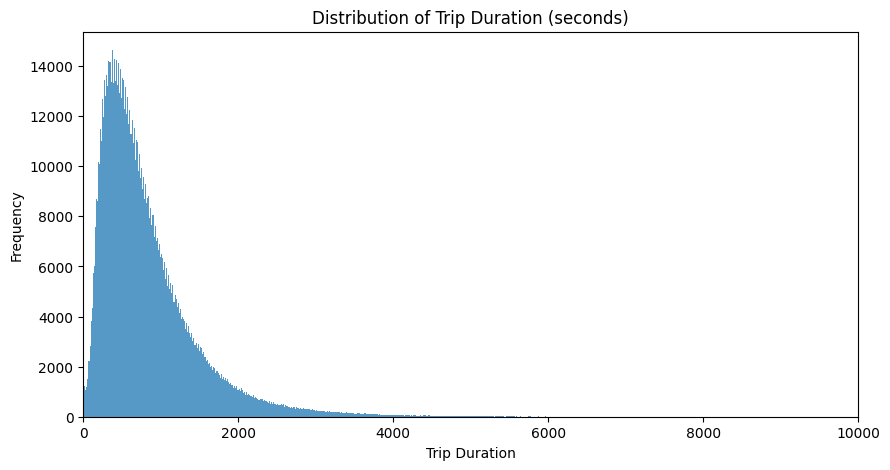

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(train['trip_duration'])
plt.xlim(0, 10000)
plt.title("Distribution of Trip Duration (seconds)")
plt.xlabel("Trip Duration")
plt.ylabel("Frequency")
# it shows that most of the trips are less than 5000 seconds, which is about 1.4 hours.
# There are some outliers in the data, which are trips that are much longer than the average trip duration.
# We can also see that the distribution is right-skewed, which means that there are more short trips than long trips.

###  Take log1p for the target

Text(0, 0.5, 'Frequency')

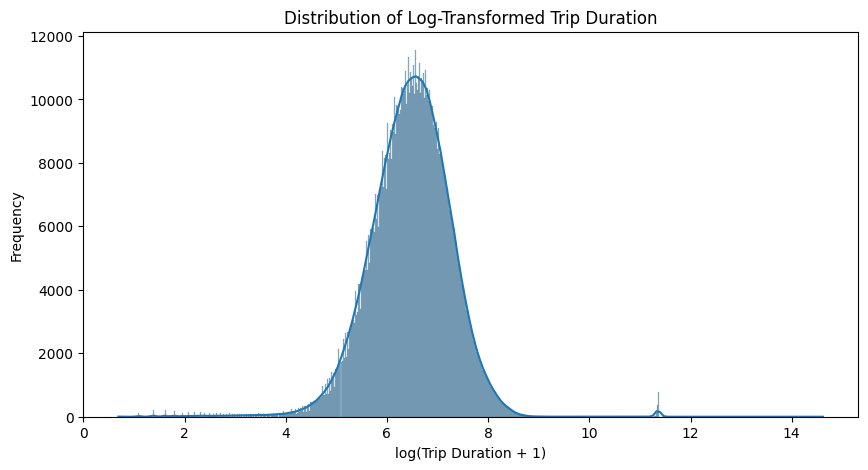

In [8]:
plt.figure(figsize=(10, 5))
train['log_trip_duration'] = np.log1p(train['trip_duration'])  # take log1p 
sns.histplot(train['log_trip_duration'], kde=True)
plt.title("Distribution of Log-Transformed Trip Duration")
plt.xlabel("log(Trip Duration + 1)")
plt.ylabel("Frequency")

## 5️⃣ Make some Feature Engineering

### Extract useful temporal features from the pickup_datetime column

Text(0.5, 1.0, 'Trips by Day of Year')

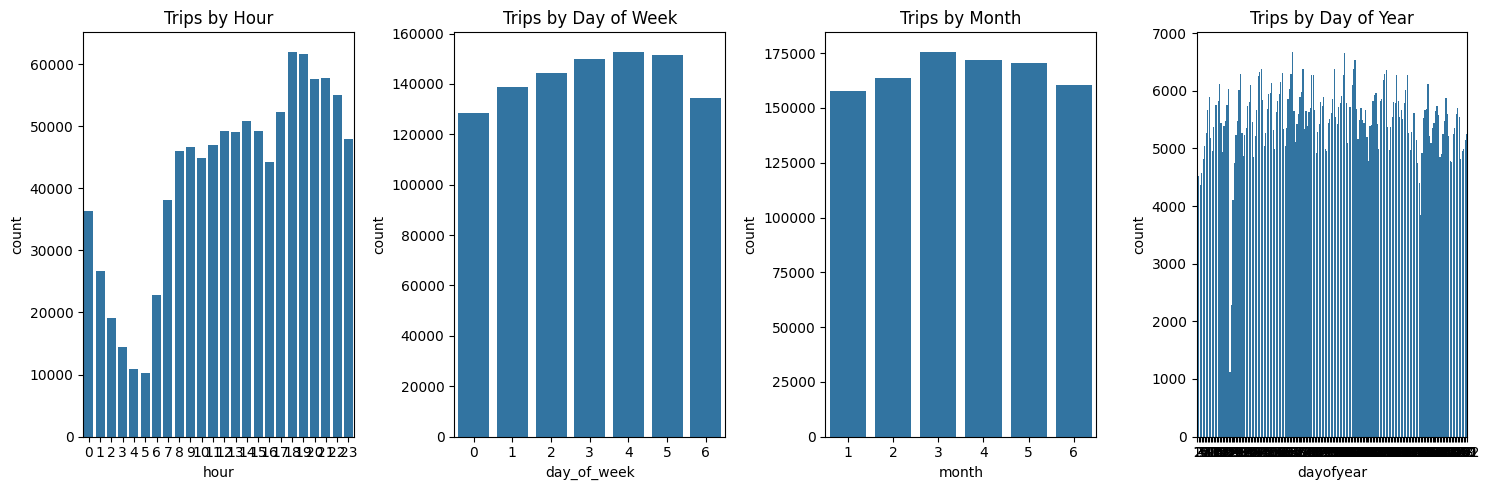

In [9]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['hour'] = train['pickup_datetime'].dt.hour
train['month'] = train['pickup_datetime'].dt.month
train['dayofyear'] = train.pickup_datetime.dt.dayofyear


fig, axs = plt.subplots(1, 4, figsize=(15, 5), tight_layout=True)
sns.countplot(data=train, x='hour', ax=axs[0])
axs[0].set_title("Trips by Hour")


sns.countplot(data=train, x='day_of_week', ax=axs[1])
axs[1].set_title("Trips by Day of Week")


sns.countplot(data=train, x='month', ax=axs[2])
axs[2].set_title("Trips by Month")


sns.countplot(data=train, x='dayofyear', ax=axs[3])
axs[3].set_title("Trips by Day of Year")

 


## Passenger Count

Check the number of passengers per trip and their impact on duration.

In [10]:
# Check unique values and their counts
passenger_counts = train['passenger_count'].value_counts().sort_index()
print(passenger_counts)

passenger_count
0        38
1    708628
2    143907
3     41012
4     19491
5     53635
6     33287
7         2
Name: count, dtype: int64


In [11]:
# remove outliers in passenger_count , I keep 0 becouse it could be realistic scenario 
outliers = [7]
train = train[~train['passenger_count'].isin(outliers)]

### Using pickup_longitude, pickup_latitude, dropoff_longitude, and dropoff_latitude, compute the straight-line distance (trip_distance) using the haversine library

In [12]:
def vec_haversine(row):
    dis =haversine((row['pickup_latitude'], row['pickup_longitude']),
                    (row['dropoff_latitude'], row['dropoff_longitude']))
    dislog = np.log1p(dis)
    return dislog


train['trip_distance'] = train.apply(vec_haversine, axis=1)

In [13]:
def manhattan_distance(row):
    manhattan_dist = abs(row['pickup_latitude'] - row['dropoff_latitude']) + abs(row['pickup_longitude'] - row['dropoff_longitude'])
    manhattan_distlog = np.log1p(manhattan_dist)
    return manhattan_distlog

train['manhattan_distance'] = train.apply(manhattan_distance, axis=1)

In [14]:
# Function to compute the bearing between two points (pickup and dropoff locations)
# The bearing is the angle between the north direction and the line connecting the two points
def Direction_bearing (row):
    lat1 = np.radians(row['pickup_latitude'])
    lat2 = np.radians(row['dropoff_latitude'])
    dlon = np.radians(row['dropoff_longitude'] - row['pickup_longitude'])
    
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    
    initial_bearing = np.arctan2(x, y)
    
    # Now we have the initial bearing in radians, convert it to degrees
    initial_bearing = np.degrees(initial_bearing)
    
    # Normalize the bearing to be between 0 and 360 degrees
    compass_bearing = (initial_bearing + 360) % 360
    
    return compass_bearing


train['bearing'] = train.apply(Direction_bearing, axis=1) 


### Calculate the average speed (distance divided by trip duration) for trips based on the day of the week and hour of the day. (for analysis only - not for training to avoid Data Leakage) 
    Use this analysis to create a categorical feature for traffic congestion levels, with categories such as:
    - 0: Light traffic
    - 1: Heavy traffic


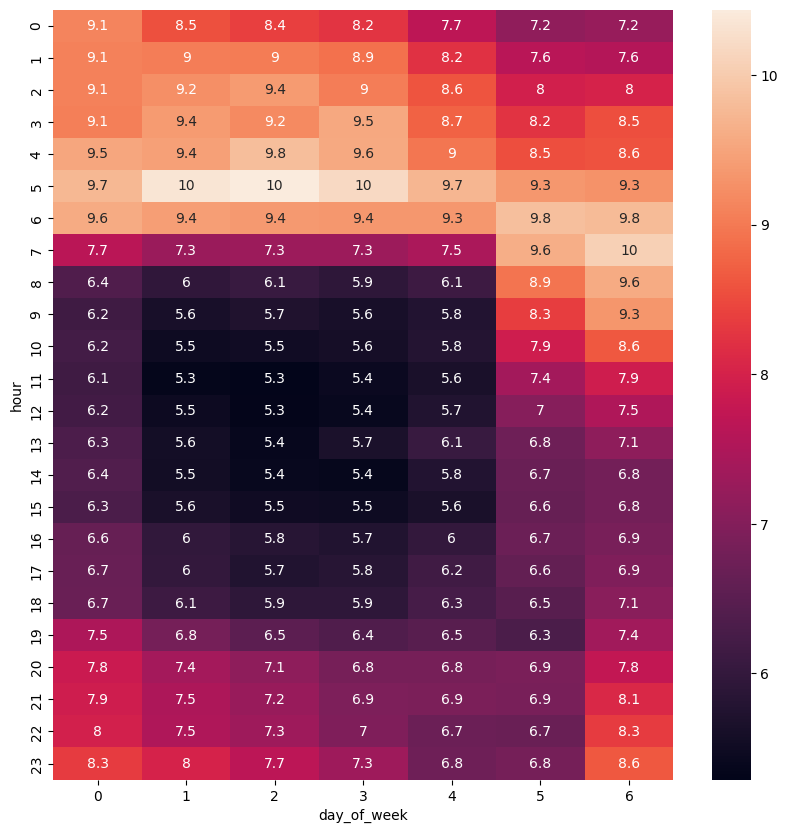

In [15]:
train['speed'] = train['trip_distance'] / (train['trip_duration'] / 3600)  # speed in km/h  


# Calculate average speed by day of the week and hour
avg_speed = train.groupby(['day_of_week', 'hour'])['speed'].mean().reset_index()
# Visualize to make decision 
fig, ax = plt.subplots(figsize=(10, 10))
df_temp = avg_speed.pivot(index='hour', columns='day_of_week', values='speed')
sns.heatmap(df_temp, annot=True, ax=ax)
plt.show()

In [16]:
train['traffic_congestion'] = 0
# Assign traffic congestion levels based on average speed
train.loc[(((8 <= train['hour']) & (train['hour'] <= 18))  # hours 8 to 18 
         &((1 <= train['day_of_week']) & (train['day_of_week'] <= 4))),  # from day 1 to day 4
        'traffic_congestion'] = 1                                           # 1 is traffic congestion

In [17]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_week,hour,month,dayofyear,trip_distance,manhattan_distance,bearing,speed,traffic_congestion
0,id2793718,2,2016-06-08 07:36:19,1,-73.985611,40.735943,-73.980331,40.760468,N,1040,6.947937,2,7,6,160,1.325231,0.029369,9.261031,4.587337,0
1,id3485529,2,2016-04-03 12:58:11,1,-73.978394,40.764351,-73.991623,40.749859,N,827,6.719013,6,12,4,94,1.084913,0.027344,214.667627,4.722715,0
2,id1816614,2,2016-06-05 02:49:13,5,-73.989059,40.744389,-73.973381,40.748692,N,614,6.421622,6,2,6,157,0.877456,0.019784,70.081271,5.144692,0
3,id1050851,2,2016-05-05 17:18:27,2,-73.990326,40.731136,-73.991264,40.748917,N,867,6.766192,3,17,5,126,1.091474,0.018546,357.710323,4.532074,1
4,id0140657,1,2016-05-12 17:43:38,4,-73.789497,40.646675,-73.987137,40.759232,N,4967,8.510773,3,17,5,133,3.083641,0.270177,306.979191,2.234972,1
